PyTorch 버전: 2.8.0+cu126
CUDA 사용 버전: 12.6
GPU: NVIDIA A100-SXM4-40GB
GPU 메모리: 39.6 GB
사용 디바이스: cuda

=== 외과 QA 파인튜닝 실습 ===
A100/고성능 GPU 감지
CUDA 상태: 정상
외과 QA 파인튜닝 실습 시작


=== 데이터 로딩 ===
PKL 파일에서 로딩: 415개

=== 모델 설정 ===
모델 로딩 완료

=== 학습 데이터 준비 ===
선택된 데이터: 100개 (A100 최적화)
포맷팅 완료: 100개

=== 토크나이징 ===


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

토크나이징 완료: 100개 (max_length=512)

=== 파인튜닝 전 답변 생성 중 ===
샘플 1 완료
샘플 2 완료
샘플 3 완료
샘플 4 완료
샘플 5 완료

=== 파인튜닝 ===
GPU 모드: A100
에포크: 5, 배치: 4, 학습률: 1e-05
FP16: True, Gradient Accumulation: 2


Step,Training Loss
2,2.387700
4,2.252000
6,2.096800
8,2.000600
10,1.926100
12,2.022100
14,1.698500
16,1.384900
18,1.470400
20,1.371900


파인튜닝 완료!
초기 Loss: 2.3877
최종 Loss: 0.3524
감소율: 85.2%

=== Loss 그래프 ===


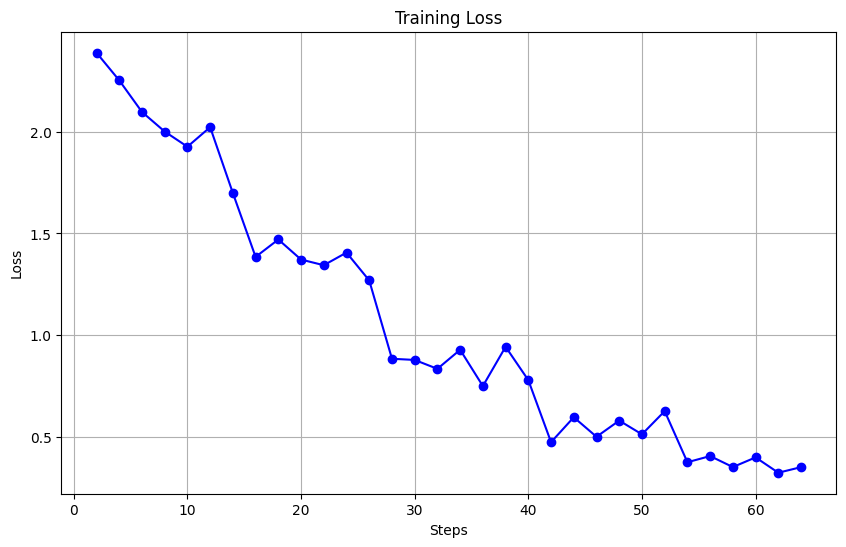


=== 파인튜닝 후 답변 생성 중 ===
샘플 1 완료
샘플 2 완료
샘플 3 완료
샘플 4 완료
샘플 5 완료

파인튜닝 전후 비교

=== 샘플 1 (단답형) ===
> 질문: 40세 남성이 오른쪽 하복부에 국한된 날카롭고 찌르는 듯한 급성 복통을 호소하며 내원했습니다. 환자는 발열이 없었고, 복부 CT에서 직경 3 cm의 타원형 병변이 관찰되었으며, 대장벽과 인접해 있고 염증 변화로 둘러싸여 있었습니다. 이 소견에서 가장 가능성이 높은 진단은 무엇인가요?
> 정답: Epiploic appendagitis
> 1. LLM 답변: This is a classic presentation of Crohn's disease, a chronic inflammatory disorder of the gastrointestinal tract. It is characterized by transmural inflammation of the bowel with loss of normal mucosal architecture and a characteristic pattern of disease. The CT findings are highly suggestive of Crohn's disease, and the presentation of a single episode of acute abdominal pain and the absence of fever are consistent with a diagnosis of Cro
> 2. 파인튜닝 후 답변: Colloid cyst of the third ventricle는 대장벽과 인접한 날카롭고 찌르는 듯한 소견으로, 염증 변화로 둘러싸인 타원형 병변이 관찰되었습니다. 이 소견에서 가장 가능성이 높은 진단은 Colloid cyst of the
개선도: 유사한 수준
--------------------------------------------------------------------------------

=== 샘플 2 (

In [5]:
# 외과 분야 의료 QA 파인튜닝 실습
# pip install transformers datasets accelerate matplotlib

"""
AI Hub 의료 데이터셋 준비: TL_Surgery.zip => 압축해제 json 파일 => pkl 파일로 통합
("q_type": 2 단답형과 3 서술형만 학습, 1 객관식은 제외)

%cd /content/drive/MyDrive/Colab Notebooks/medical_finetuning_dataset
!pwd
!apt-get install p7zip-full -y
!7z x "/content/drive/MyDrive/Colab Notebooks/medical_finetuning_dataset/TL_Surgery.zip"
!ls *.pkl -al
!rm -f medical_finetuning_dataset.pkl
"""

"""
GPU 환경 설정: A100, T4, 일반
1. 자동 GPU 감지: SimpleSurgicalFineTuning()
2. T4 GPU 설정: SimpleSurgicalFineTuning("T4")
3. A100 GPU 설정: SimpleSurgicalFineTuning("A100")
4. CPU 모드: SimpleSurgicalFineTuning("CPU")
"""

import torch
import os
import warnings
import matplotlib.pyplot as plt
import json
import pickle
import random
import numpy as np
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    TrainingArguments,
    Trainer,
    DataCollatorForLanguageModeling,
    TrainerCallback
)
from datasets import Dataset

# 경고 제거
warnings.filterwarnings("ignore")
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ["WANDB_DISABLED"] = "true"
os.environ["TRANSFORMERS_VERBOSITY"] = "error"

# GPU 환경 확인
print(f"PyTorch 버전: {torch.__version__}")

if torch.cuda.is_available():
    print(f"CUDA 사용 버전: {torch.version.cuda}")
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(
        f"GPU 메모리: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")
    device = 'cuda'
else:
    print("CPU 전용 모드")
    device = 'cpu'
print(f"사용 디바이스: {device}")
print()


class LossTrackingCallback(TrainerCallback):
    def __init__(self):
        self.training_losses = []
        self.steps = []

    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs and 'loss' in logs:
            self.training_losses.append(logs['loss'])
            self.steps.append(state.global_step)


class SimpleSurgicalFineTuning:
    def __init__(self, gpu_mode="AUTO"):
        print("=== 외과 QA 파인튜닝 실습 ===")

        # GPU 모드 설정
        if gpu_mode == "AUTO":
            # 자동 감지
            if torch.cuda.is_available():
                gpu_name = torch.cuda.get_device_name(0)
                gpu_memory = torch.cuda.get_device_properties(
                    0).total_memory / 1024**3

                if "A100" in gpu_name or gpu_memory > 30:
                    print("A100/고성능 GPU 감지")
                    self.gpu_mode = "A100"
                elif "T4" in gpu_name or gpu_memory < 20:
                    print("T4 GPU 자동 감지")
                    self.gpu_mode = "T4"
                else:
                    print("일반 GPU 감지")
                    self.gpu_mode = "STANDARD"
            else:
                print("CPU 모드 감지")
                self.gpu_mode = "CPU"
        else:
            # 수동 설정
            self.gpu_mode = gpu_mode.upper()
            print(f"{self.gpu_mode} 모드로 수동 설정")

        # CUDA 설정
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
            print("CUDA 상태: 정상")

        self.model_name = "meta-llama/Llama-3.2-1B"
        self.device = torch.device(
            "cuda" if torch.cuda.is_available() else "cpu")

        # 경로 설정
        self.dataset_dir = "/content/drive/MyDrive/Colab Notebooks/medical_finetuning_dataset"
        self.pkl_path = os.path.join(
            self.dataset_dir, "medical_finetuning_dataset.pkl")
        self.output_dir = "/tmp/simple_surgical_finetuning"
        os.makedirs(self.output_dir, exist_ok=True)

        self.loss_callback = LossTrackingCallback()
        self.training_data = []
        self.original_qa_pairs = []  # 원본 정답 저장용

    def load_data(self):
        print("\n=== 데이터 로딩 ===")

        # PKL 파일 확인
        if os.path.exists(self.pkl_path):
            with open(self.pkl_path, 'rb') as f:
                all_data = pickle.load(f)
            print(f"PKL 파일에서 로딩: {len(all_data)}개")
            return all_data

        # JSON 파일에서 생성
        if not os.path.exists(self.dataset_dir):
            os.makedirs(self.dataset_dir, exist_ok=True)
            print("JSON 파일들을 업로드해주세요")
            return []

        json_files = [f for f in os.listdir(
            self.dataset_dir) if f.endswith('.json')]
        print(f"JSON 파일 {len(json_files)}개 발견")

        all_data = []
        for filename in json_files:
            try:
                with open(os.path.join(self.dataset_dir, filename), 'r', encoding='utf-8-sig') as f:
                    data = json.load(f)
                if (data.get('domain') == 1 and data.get('q_type') in [2, 3] and
                        len(str(data.get('question', ''))) > 10 and len(str(data.get('answer', ''))) > 5):
                    all_data.append(data)
            except:
                continue

        print(f"로딩 완료: {len(all_data)}개")

        # PKL 저장
        try:
            with open(self.pkl_path, 'wb') as f:
                pickle.dump(all_data, f)
        except Exception as e:
            print(f"PKL 파일 저장 실패: {e}")

        return all_data

    def prepare_data(self, raw_data):
        print("\n=== 학습 데이터 준비 ===")

        if not raw_data:
            return None

        # 단답형(2), 서술형(3) 분리
        type_2_data = [item for item in raw_data if item.get('q_type') == 2]
        type_3_data = [item for item in raw_data if item.get('q_type') == 3]

        # GPU에 따른 데이터 수 설정
        if self.gpu_mode == "A100":
            NUM_SAMPLES = 100  # A100: 100, 더 많은 학습
        elif self.gpu_mode == "T4":
            NUM_SAMPLES = 20   # T4: 20 (메모리 절약)
        else:
            NUM_SAMPLES = 50   # 일반: 50

        selected_data = []
        if type_2_data:
            random.shuffle(type_2_data)
            selected_data.extend(type_2_data[:NUM_SAMPLES//2])
        if type_3_data:
            random.shuffle(type_3_data)
            selected_data.extend(type_3_data[:NUM_SAMPLES//2])

        print(f"선택된 데이터: {len(selected_data)}개 ({self.gpu_mode} 최적화)")

        # GPU에 따른 텍스트 길이 설정
        if self.gpu_mode == "A100":
            max_q_len, max_a_len = 300, 200
        elif self.gpu_mode == "T4":
            max_q_len, max_a_len = 100, 80
        else:
            max_q_len, max_a_len = 200, 150

        # 텍스트 형식 변환
        formatted_data = []
        for item in selected_data:
            try:
                question = str(item['question']).strip()[:max_q_len]
                answer = str(item['answer']).strip()[:max_a_len]

                # 원본 QA 쌍 저장 (비교용)
                self.original_qa_pairs.append({
                    "question": question,
                    "answer": answer,
                    "q_type": item.get('q_type', 'unknown')
                })

                text = f"질문: {question}\n답변: {answer}"
                formatted_data.append({"text": text})
            except:
                continue

        print(f"포맷팅 완료: {len(formatted_data)}개")
        return Dataset.from_list(formatted_data)

    def setup_model(self):
        print("\n=== 모델 설정 ===")

        # 토크나이저
        self.tokenizer = AutoTokenizer.from_pretrained(self.model_name)
        if self.tokenizer.pad_token is None:
            self.tokenizer.pad_token = self.tokenizer.eos_token

        # 모델
        self.model = AutoModelForCausalLM.from_pretrained(
            self.model_name,
            torch_dtype=torch.float32,  # T4: float32로 안정성 확보
            device_map="auto",
            use_cache=False  # gradient checkpointing 호환
        )

        print("모델 로딩 완료")

    def tokenize_data(self, dataset):
        print("\n=== 토크나이징 ===")

        # GPU에 따른 시퀀스 길이 설정
        if self.gpu_mode == "A100":
            MAX_LENGTH = 512  # A100: 512, 긴 시퀀스 처리 가능
        elif self.gpu_mode == "T4":
            MAX_LENGTH = 128  # T4: 128 (메모리 절약)
        else:
            MAX_LENGTH = 256  # 일반: 256

        def tokenize_function(examples):
            result = self.tokenizer(
                examples["text"],
                truncation=True,
                padding="max_length",
                max_length=MAX_LENGTH,
                return_tensors="pt"
            )
            result["labels"] = result["input_ids"].clone()
            return result

        tokenized_dataset = dataset.map(
            tokenize_function,
            batched=True,
            remove_columns=dataset.column_names
        )

        print(f"토크나이징 완료: {len(tokenized_dataset)}개 (max_length={MAX_LENGTH})")
        return tokenized_dataset

    def test_qa_generation(self, stage=""):
        print(f"\n=== {stage} 답변 생성 중 ===")

        # 훈련 데이터에서 5개 선택
        test_samples = self.original_qa_pairs[:5] if len(
            self.original_qa_pairs) >= 5 else self.original_qa_pairs

        results = []
        self.model.eval()

        for i, sample in enumerate(test_samples):
            question = sample["question"]
            original_answer = sample["answer"]
            q_type = sample["q_type"]

            try:
                prompt = f"질문: {question}\n답변:"
                inputs = self.tokenizer(
                    prompt, return_tensors="pt").to(self.device)

                # GPU에 따른 생성 길이 설정
                max_tokens = 80 if self.gpu_mode == "A100" else 50

                with torch.no_grad():
                    outputs = self.model.generate(
                        inputs.input_ids,
                        max_new_tokens=max_tokens,
                        temperature=0.7,
                        pad_token_id=self.tokenizer.pad_token_id,
                        do_sample=True
                    )

                response = self.tokenizer.decode(
                    outputs[0], skip_special_tokens=True)
                response = response.split("답변:")[-1].strip()

            except Exception as e:
                response = f"오류: {str(e)[:30]}"

            print(f"샘플 {i+1} 완료")

            results.append({
                "question": question,
                "original_answer": original_answer,
                "generated_answer": response,
                "q_type": q_type
            })

        self.model.train()
        return results

    # 파인튜닝 전후 비교, 통합 출력
    def show_comparison_results(self, results_before, results_after):
        print("\n" + "="*80)
        print("파인튜닝 전후 비교")
        print("="*80)

        for i, (before, after) in enumerate(zip(results_before, results_after)):
            q_type_name = "단답형" if before['q_type'] == 2 else "서술형" if before['q_type'] == 3 else "기타"

            print(f"\n=== 샘플 {i+1} ({q_type_name}) ===")
            print(f"> 질문: {before['question']}")
            print(f"> 정답: {before['original_answer']}")
            print(f"> 1. LLM 답변: {before['generated_answer']}")
            print(f"> 2. 파인튜닝 후 답변: {after['generated_answer']}")

            # 간단한 개선도 평가
            improvements = []
            if len(after['generated_answer']) > len(before['generated_answer']):
                improvements.append("더 상세한 답변")
            if "오류" not in after['generated_answer'] and "오류" in before['generated_answer']:
                improvements.append("오류 해결")
            if not improvements:
                improvements.append("유사한 수준")

            print(f"개선도: {', '.join(improvements)}")
            print("-" * 80)

    def plot_training_loss(self):
        print("\n=== Loss 그래프 ===")

        if not self.loss_callback.training_losses:
            return

        plt.figure(figsize=(10, 6))
        plt.plot(self.loss_callback.steps,
                 self.loss_callback.training_losses, 'b-o')
        plt.title('Training Loss')
        plt.xlabel('Steps')
        plt.ylabel('Loss')
        plt.grid(True)
        plt.savefig(f'{self.output_dir}/loss_plot.png')
        plt.show()

    def fine_tune(self, tokenized_dataset):
        print("\n=== 파인튜닝 ===")

        # GPU에 따른 최적화 파라미터
        if self.gpu_mode == "A100":
            EPOCHS = 5              # A100: 5 에포크
            BATCH_SIZE = 4          # A100: 4 배치
            GRAD_ACCUMULATION = 2   # A100: 2 accumulation
            LEARNING_RATE = 1e-5    # A100: 낮은 학습률
            USE_FP16 = True         # A100: FP16 사용 가능
        elif self.gpu_mode == "T4":
            EPOCHS = 3              # T4: 3 에포크
            BATCH_SIZE = 1          # T4: 1 배치
            GRAD_ACCUMULATION = 8   # T4: 8 accumulation
            LEARNING_RATE = 2e-5    # T4: 적당한 학습률
            USE_FP16 = False        # T4: FP32 안정성
        else:
            EPOCHS = 4              # 일반: 4 에포크
            BATCH_SIZE = 2          # 일반: 2 배치
            GRAD_ACCUMULATION = 4   # 일반: 4 accumulation
            LEARNING_RATE = 1.5e-5  # 일반: 중간 학습률
            USE_FP16 = True         # 일반: FP16 사용

        training_args = TrainingArguments(
            output_dir=self.output_dir,
            num_train_epochs=EPOCHS,
            per_device_train_batch_size=BATCH_SIZE,
            gradient_accumulation_steps=GRAD_ACCUMULATION,
            learning_rate=LEARNING_RATE,
            warmup_steps=10,
            logging_steps=2,
            save_strategy="no",
            fp16=USE_FP16,
            dataloader_num_workers=0,
            report_to=[],
            remove_unused_columns=False,
        )

        data_collator = DataCollatorForLanguageModeling(
            tokenizer=self.tokenizer,
            mlm=False
        )

        trainer = Trainer(
            model=self.model,
            args=training_args,
            train_dataset=tokenized_dataset,
            data_collator=data_collator,
            callbacks=[self.loss_callback]
        )

        print(f"GPU 모드: {self.gpu_mode}")
        print(f"에포크: {EPOCHS}, 배치: {BATCH_SIZE}, 학습률: {LEARNING_RATE}")
        print(f"FP16: {USE_FP16}, Gradient Accumulation: {GRAD_ACCUMULATION}")

        try:
            # GPU 메모리 정리
            if torch.cuda.is_available():
                torch.cuda.empty_cache()

            trainer.train()
            print("파인튜닝 완료!")

            if self.loss_callback.training_losses:
                initial_loss = self.loss_callback.training_losses[0]
                final_loss = self.loss_callback.training_losses[-1]
                print(f"초기 Loss: {initial_loss:.4f}")
                print(f"최종 Loss: {final_loss:.4f}")
                print(
                    f"감소율: {(initial_loss - final_loss) / initial_loss * 100:.1f}%")
                self.plot_training_loss()

            return True

        except Exception as e:
            print(f"파인튜닝 오류: {str(e)}")
            if "out of memory" in str(e).lower() or "cuda" in str(e).lower():
                print("메모리 부족 해결 방법:")
                print("1. BATCH_SIZE 줄이기")
                print("2. GRAD_ACCUMULATION을 2배로 늘리기")
                print("3. 런타임 재시작 후 다시 시도")

            # 메모리 정리
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
            return False

    def run_demo(self):
        try:
            print("외과 QA 파인튜닝 실습 시작\n")

            # 1. 데이터 로딩
            raw_data = self.load_data()
            if not raw_data:
                return

            # 2. 모델 설정
            self.setup_model()

            # 3. 데이터 준비
            dataset = self.prepare_data(raw_data)
            if not dataset:
                return

            tokenized_dataset = self.tokenize_data(dataset)

            # 4. 파인튜닝 전 답변 생성
            results_before = self.test_qa_generation("파인튜닝 전")

            # 5. 파인튜닝
            success = self.fine_tune(tokenized_dataset)

            if success:
                # 6. 파인튜닝 후 답변 생성
                results_after = self.test_qa_generation("파인튜닝 후")

                # 7. 통합 비교 결과 출력
                self.show_comparison_results(results_before, results_after)

                print(f"\n실습 완료! ({self.gpu_mode} GPU 최적화)")

        except Exception as e:
            print(f"실습 오류: {str(e)}")


def main():
    # GPU 모드 선택
    # 1. 자동 감지 (기본값)
    demo = SimpleSurgicalFineTuning()  # 또는 SimpleSurgicalFineTuning("AUTO")

    # 2. T4 GPU 설정
    # demo = SimpleSurgicalFineTuning("T4")

    # 3. A100 GPU 설정
    # demo = SimpleSurgicalFineTuning("A100")

    # 4. CPU 모드 설정
    # demo = SimpleSurgicalFineTuning("CPU")

    demo.run_demo()


if __name__ == "__main__":
    main()
